In [3]:
import cv2
import numpy as np
import pandas as pd
from skimage.feature import graycomatrix, graycoprops, local_binary_pattern
from skimage import img_as_ubyte
import matplotlib.pyplot as plt 
import os
from tqdm import tqdm


<>:1: SyntaxWarning: invalid escape sequence '\R'
<>:1: SyntaxWarning: invalid escape sequence '\R'
C:\Users\SuongLe\AppData\Local\Temp\ipykernel_9160\2527368498.py:1: SyntaxWarning: invalid escape sequence '\R'
  img_path = 'D:\Rice_photos\Rice_photos\BC-15\BC-15\DSC6771_idx1.png'


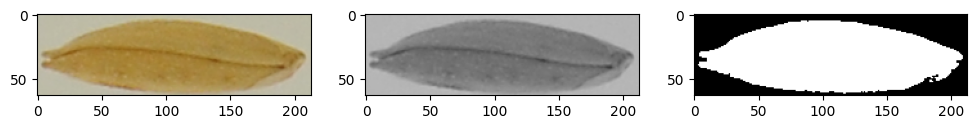

In [3]:
img_path = 'D:\Rice_photos\Rice_photos\BC-15\BC-15\DSC6771_idx1.png'
image = cv2.imread(img_path)
gray_img = cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)
image2 = cv2.imread(img_path)
_, binary = cv2.threshold(gray_img, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
figs,axs = plt.subplots(1,3, figsize =(12,4))

contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)


axs[0].imshow(cv2.cvtColor(image,cv2.COLOR_RGB2BGR))
axs[1].imshow(cv2.cvtColor(gray_img,cv2.COLOR_RGB2BGR))
axs[2].imshow(cv2.cvtColor(binary,cv2.COLOR_RGB2BGR))

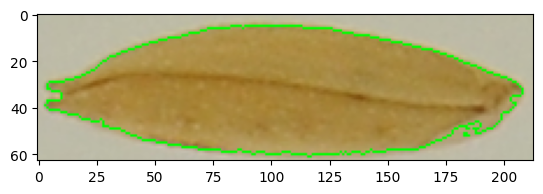

In [4]:
output_image = image.copy()
valid_contours = [contour for contour in contours if cv2.contourArea(contour) > 500]

cv2.drawContours(output_image, contours, -1, (0, 255, 0), 1)
plt.imshow(cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB))

3
206


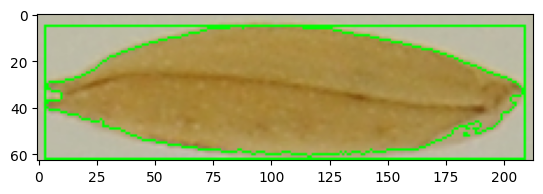

In [5]:
for contour in contours:
    x, y, width, height = cv2.boundingRect(contour)
    print(max(height,width))   
    if width > 5 and height > 5:
        cv2.rectangle(output_image, (x, y), (x + width, y + height), (0, 255, 0), 1)

plt.imshow(cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB))


((105.66117858886719, 32.6317138671875), (204.6141357421875, 55.82655715942383), 2.385944128036499)


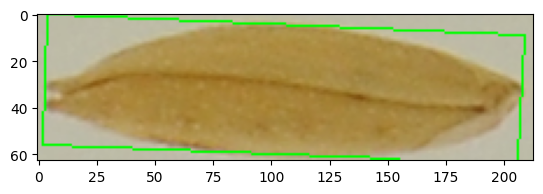

In [6]:
output_2 = image.copy()
for contour in valid_contours:
    min_rect = cv2.minAreaRect(contour)  
    box = cv2.boxPoints(min_rect)      
    box = np.int32(box)        
    print(min_rect)
    cv2.drawContours(output_2, [box], 0, (0, 255, 0), 1)  # Green rectangle
plt.imshow(cv2.cvtColor(output_2, cv2.COLOR_BGR2RGB))

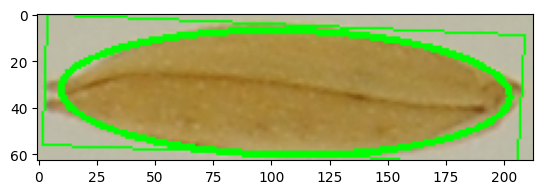

In [7]:
ellipse = cv2.fitEllipse(contour)
cv2.ellipse(output_2, ellipse, (0, 255, 0), 2)
plt.imshow(cv2.cvtColor(output_2, cv2.COLOR_BGR2RGB))

In [4]:
def extract_basic_features(image_path):
    image = cv2.imread(image_path)
    gray_img = cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)
    #image2 = cv2.imread(img_path)

    _, binary = cv2.threshold(gray_img, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    valid_contours = [contour for contour in contours if cv2.contourArea(contour) > 1000]
    if len(valid_contours) == 0:
        return []
    
    contour = max(valid_contours, key = cv2.contourArea)
    features = []
    
    #Color
    mean_r = np.mean(image[:,:,2])
    mean_g = np.mean(image[:,:,1])
    mean_b = np.mean(image[:,:,0])

    red_sqr = np.sqrt(mean_r)
    green_sqr = np.sqrt(mean_g)
    blue_sqr = np.sqrt(mean_b)

    #Texture

    hist = cv2.calcHist([gray_img],[0],None, [256], [0,256])
    hist = hist/hist.sum()

    intensities = np.arange(256)
    mean = np.sum(intensities * hist.flatten())
    std = np.sqrt(np.sum((intensities-mean)**2 *hist.flatten()))
    uniformity = np.sum(hist.flatten()**2)
    third_moment = np.sum((intensities-mean)**3 * hist.flatten())


    #Morphological descriptors

    area = cv2.contourArea(contour)
    
    min_rect = cv2.minAreaRect(contour)
    length = max(min_rect[1])
    width = min(min_rect[1])

    ratioLW = length/width

    hull = cv2.convexHull(contour)
    hull_area = cv2.contourArea(hull)
    hull_perimeter = cv2.arcLength(hull,True)

    ellipse = cv2.fitEllipse(contour)
    major_axis_length = max(ellipse[1])
    minor_axis_length = min(ellipse[0])




    return {
        "area": area,
        "length": length,
        "width": width,
        "aspect_ratio": ratioLW,
        "major_axis_length": major_axis_length,
        "minor_axis_length": minor_axis_length,
        "convex_hull_area": hull_area,
        "convex_hull_perimeter": hull_perimeter,
        "mean_r": mean_r,
        "mean_g": mean_g,
        "mean_b": mean_b,
        "red_sqr": red_sqr,
        "green_sqr": green_sqr,
        "blue_sqr": blue_sqr,
        "texture_mean": mean,
        "texture_std": std,
        "texture_uniformity": uniformity,
        "texture_third_moment": third_moment
    }

In [5]:
def process_directory(base_path):
    all_features = []
    all_labels = []
    image_paths = []

    for root, dirs, files in os.walk(base_path):
        for file in files:
            if file.endswith(('.png', '.jpg', '.jpeg')):
                label = 0 if 'Negative' in root else 1
                image_paths.append((os.path.join(root, file), label))
    
    for image_path, label in tqdm(image_paths, desc="Processing"):
        features = extract_basic_features(image_path)
        if features is not None:
            all_features.append(features)
            all_labels.append(label)
    
    df = pd.DataFrame(all_features)
    df['label'] = all_labels
    
    return df

In [23]:
base_path = r'D:\Rice_photos\Rice_photos\Xi23'
df = process_directory(base_path)

Processing:   0%|          | 0/4145 [00:00<?, ?it/s]

Processing: 100%|██████████| 4145/4145 [00:06<00:00, 603.23it/s]


In [24]:
df

,area,length,width,aspect_ratio,major_axis_length,minor_axis_length,convex_hull_area,convex_hull_perimeter,mean_r,mean_g,mean_b,red_sqr,green_sqr,blue_sqr,texture_mean,texture_std,texture_uniformity,texture_third_moment,label
0,7589.5,190.000000,52.000000,3.653846,186.729904,31.942726,7865.0,416.629805,155.303877,131.696517,82.939667,12.462098,11.475910,9.107122,119.807944,39.988110,0.028898,18007.706309,0
1,12740.0,249.000000,67.000000,3.716418,241.836594,38.002972,13174.5,540.566448,169.220168,145.139088,85.663509,13.008465,12.047369,9.255458,130.107054,30.732486,0.026090,14134.541135,0
2,11122.0,222.000000,66.000000,3.363636,211.227097,37.291161,11491.0,486.333366,170.958830,149.445556,88.079883,13.075123,12.224793,9.385088,133.556200,29.026857,0.032191,11962.142586,0
3,11031.0,228.000000,63.000000,3.619048,228.557007,38.088200,11405.0,497.821687,166.382883,140.784183,83.496408,12.898949,11.865251,9.137637,126.575665,34.586685,0.035630,20032.060509,0
4,8659.5,195.000000,60.000000,3.250000,186.242523,36.011509,8972.0,427.327620,159.441176,138.846405,89.172279,12.627002,11.783310,9.443107,126.346903,36.348264,0.029662,8605.782226,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4140,12060.0,230.000000,68.000000,3.382353,222.469894,38.574894,12417.0,503.897493,163.613668,142.027787,90.301041,12.791156,11.917541,9.502686,129.028967,31.939545,0.030637,15150.267308,1
4141,10965.0,208.000000,68.000000,3.058824,203.560928,35.677589,11229.5,465.046475,172.786245,154.227461,98.796662,13.144818,12.418835,9.939651,139.777595,24.449359,0.032843,7883.992964,1
4142,9288.0,225.000000,59.000000,3.813559,207.829590,32.305050,9569.0,479.167592,169.343012,149.793489,99.442496,13.013186,12.239015,9.972086,136.987937,31.002725,0.036240,5840.383487,1
4143,9586.5,220.000000,57.000000,3.859649,214.066833,34.919102,9829.5,474.314780,165.104216,138.746007,88.866523,12.849289,11.779049,9.426904,126.838439,36.773440,0.029380,19223.170963,1


In [25]:
df.to_csv('basic_descriptor_Xi23.csv',index=False)